<a href="https://colab.research.google.com/github/AldoKwamibar/Pd-membranes-permeability/blob/main/palladium_membrane_ml_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
This section is a material informatics project aiming to build a quantitative composition-structure-property (QSPR) relationship between palladium-based alloys membranes and their hydrogen permeability.
...
"""

'\nThis section is a material informatics project aiming to build a quantitative composition-structure-property (QSPR) relationship between palladium-based alloys membranes and their hydrogen permeability.\n...\n'

In [ ]:
# Utilities to visualize periodic table and Element Counts in a material Informatics database
!pip install pymatgen matminer

In [ ]:
!pip install ydata-profiling

In [ ]:
# Import useful packages and dependencies
import os
import pandas as pd
import numpy as np
import scipy as sc
import re
from ydata_profiling import ProfileReport # This library is handy at generating automatic EDA report
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import pickle
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina' #Allow image to have high resolution
np.random.seed(42) # Ensure reproducibility

In [ ]:
from pymatgen.core import Element, Composition
from matminer.featurizers.composition import ElementFraction
from matminer.featurizers.conversions import StrToComposition

In [ ]:
# Mounting google drive to import and export file from and to it
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting this options allow Pandas to display every columns. By default only few are displayed.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
%%time
file_path = '/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/Pd_membrane_data_preprocessed.pkl'
df = pd.read_pickle(file_path)
print(f'Original DataFrame shape: {df.shape}')

Original DataFrame shape: (2223, 56)
CPU times: user 57.9 ms, sys: 2 ms, total: 59.9 ms
Wall time: 74.4 ms


In [ ]:
%%time
# We define an absolute path to save figures
Figure_dir='/content/drive/MyDrive/PhD_Pd alloy prediction/Figures_Pd_Permeability_Prediction'

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [ ]:
%%time
#A view of the dataset
df.head()

CPU times: user 199 µs, sys: 0 ns, total: 199 µs
Wall time: 204 µs


Alloy Formula Composition type  Form Composition in mole percent  \
0            Pd     mole percent  foil                          Pd   
1            Pd     mole percent  disc                          Pd   
2            Pd     mole percent  disc                          Pd   
3            Pd     mole percent  disc                          Pd   
4            Pd     mole percent  disc                          Pd   

   Thickness (m)  Lattice parameter (m) Bravais lattice  Temperature (K)  \
0        0.00025           3.887000e-10             fcc           737.15   
1        0.00070           3.890000e-10             fcc           673.15   
2        0.00070           3.890000e-10             fcc           673.15   
3        0.00070           3.890000e-10             fcc           673.15   
4        0.00070           3.890000e-10             fcc           623.15   

   Fabrication technique  Pressure difference P1^n-P2^n (Pa^n)  \
0  Commercial Alfa Aesar                              325.7194   
1           Cold rolling                              730.0685   
2           Cold rolling                              632.4555   
3           Cold rolling                              516.7204   
4           Cold rolling                              816.7007   

   Pressure exponent n  Permeability (mol/m/s/Pa^n)  \
0                  0.5                 9.240000e-09   
1                  0.5                 1.320000e-08   
2                  0.5                 1.260000e-08   
3                  0.5                 1.260000e-08   
4                  0.5                 1.120000e-08   

                                    General comments  \
0  Membrane A see the supplementary materials in ...   
1  Table 1 data were extracted for equation 7. Th...   
2  Table 1 data were extracted for equation 7. Th...   
3  Table 1 data were extracted for equation 7. Th...   
4  Table 1 data were extracted for equation 7. Th...   

                   Reference                                       DOI/URL  \
0  (Guerreiro  et al., 2016)  https://doi.org/10.1016/j.memsci.2016.02.040   
1    (Sakamoto et al., 1992)  https://doi.org/10.1016/0925-8388(92)90468-O   
2    (Sakamoto et al., 1992)  https://doi.org/10.1016/0925-8388(92)90468-O   
3    (Sakamoto et al., 1992)  https://doi.org/10.1016/0925-8388(92)90468-O   
4    (Sakamoto et al., 1992)  https://doi.org/10.1016/0925-8388(92)90468-O   

  Composition_matrix    B   Al   Ti    V   Cr   Mn   Fe   Co   Ni   Cu   Zn  \
0               (Pd)  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1               (Pd)  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2               (Pd)  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3               (Pd)  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4               (Pd)  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    Ga    Y   Zr   Nb   Mo   Ru   Rh   Pd   Ag   In   Sn   La   Ce   Pr   Sm  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    Gd   Tb   Dy   Ho   Er   Tm   Yb   Lu   Ta    W   Ir   Pt   Au   Pb  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [ ]:
# %%time
# # Transform the temperature into inverse temperature 1000/T and the permeability into log10 scale
# dfc = df.copy()
# # dfc[['invT', 'log(Φ)']]=dfc[['Temperature (K)', 'Permeability (mol/m/s/Pa^n)']].transfrom({'Temperature (K)': lambda x: 1000/x,
# #                                        'Permeability (mol/m/s/Pa^n)': lambda x: np.log10(x+1)}
# #                                       )

# dfc['log(Φ)']=dfc.apply({'Permeability (mol/m/s/Pa^n)': lambda x: np.log1p(x)})
# log_Perm = dfc.pop('log(Φ)')
# dfc.insert(12, 'log(Φ)', log_Perm)

In [ ]:
%%time
# Renaming columns to remove unit, we will handle unit during plotting ourselves
# Define a Function to rename dataframe

#%%
def rename_dataframe_cols(dataframe, rename_dict):
  dataframe=dataframe.rename(columns=rename_dict)
  return dataframe

#%%
rename_dict = {'Thickness (m)':'Thickness',
               'Lattice parameter (m)':'Lattice parameter',
               'Temperature (K)':'Temperature',
               'Pressure difference P1^n-P2^n (Pa^n)':'Pressure difference',
               'Pressure exponent n':'Pressure exponent',
               'Permeability (mol/m/s/Pa^n)':'Permeability'}

df=rename_dataframe_cols(dataframe=df, rename_dict=rename_dict)
# dataframe = dataframe.drop(columns=['Permeability'], errors='raise')

CPU times: user 2.61 ms, sys: 0 ns, total: 2.61 ms
Wall time: 2.62 ms


In [ ]:
%%time
df.describe()
# This indicates no missing values

CPU times: user 307 ms, sys: 3 ms, total: 310 ms
Wall time: 317 ms


Thickness  Lattice parameter  Temperature  Pressure difference  \
count  2223.000000       2.223000e+03  2223.000000          2223.000000   
mean      0.000118       3.768975e-10   626.772807           436.866830   
std       0.000187       3.320090e-11   132.121494           420.423109   
min       0.000001       2.874000e-10   292.330000             9.335500   
25%       0.000025       3.865500e-10   525.730000           216.227800   
50%       0.000091       3.903000e-10   623.150000           350.855400   
75%       0.000100       3.935000e-10   722.720000           552.786400   
max       0.001100       4.041000e-10  1174.560000          4377.565700   

       Pressure exponent  Permeability            B           Al           Ti  \
count             2223.0  2.223000e+03  2223.000000  2223.000000  2223.000000   
mean                 0.5  1.935819e-08     0.000042     0.000976     0.000711   
std                  0.0  1.962539e-08     0.001412     0.005835     0.007854   
min                  0.5  0.000000e+00     0.000000     0.000000     0.000000   
25%                  0.5  5.900000e-09     0.000000     0.000000     0.000000   
50%                  0.5  1.230000e-08     0.000000     0.000000     0.000000   
75%                  0.5  2.570000e-08     0.000000     0.000000     0.000000   
max                  0.5  9.540000e-08     0.047100     0.060000     0.104700   

                 V           Cr           Mn           Fe           Co  \
count  2223.000000  2223.000000  2223.000000  2223.000000  2223.000000   
mean      0.000081     0.000036     0.000145     0.001655     0.000194   
std       0.001834     0.001697     0.002083     0.012751     0.002411   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.080000     0.080000     0.080000     0.190000     0.080000   

                Ni           Cu           Zn           Ga            Y  \
count  2223.000000  2223.000000  2223.000000  2223.000000  2223.000000   
mean      0.002723     0.120378     0.000036     0.000013     0.009248   
std       0.016441     0.212838     0.001697     0.000459     0.024635   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.130000     0.000000     0.000000     0.000000   
max       0.170000     0.937800     0.080000     0.020000     0.102000   

                Zr           Nb           Mo           Ru           Rh  \
count  2223.000000  2223.000000  2223.000000  2223.000000  2223.000000   
mean      0.000109     0.000109     0.000122     0.002389     0.000151   
std       0.002045     0.001733     0.002140     0.012134     0.003281   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.080000     0.050000     0.053000     0.104700     0.103100   

                Pd           Ag           In           Sn           La  \
count  2223.000000  2223.000000  2223.000000  2223.000000  2223.000000   
mean      0.789042     0.045740     0.002020     0.000540     0.000126   
std       0.188469     0.096437     0.010771     0.006134     0.002242   
min       0.062200     0.000000     0.000000     0.000000     0.000000   
25%       0.700000     0.000000     0.000000     0.000000     0.000000   
50%       0.882000     0.000000     0.000000     0.000000     0.000000   
75%       0.938900     0.000000     0.000000     0.000000     0.000000   
max       

In [ ]:
df.nsmallest(200, 'Permeability')

Alloy Formula Composition type  Form Composition in mole percent  \
124                    Pd     mole percent  foil                          Pd   
129                    Pd     mole percent  foil                          Pd   
135          Pd20.0Cu80.0   weight percent  foil              Pd12.99Cu87.01   
136          Pd20.0Cu80.0   weight percent  foil              Pd12.99Cu87.01   
137          Pd20.0Ag80.0   weight percent  foil              Pd20.22Ag79.78   
138          Pd20.0Ag80.0   weight percent  foil              Pd20.22Ag79.78   
141          Pd40.0Cu60.0   weight percent  foil              Pd28.48Cu71.52   
144          Pd40.0Cu60.0   weight percent  foil              Pd28.48Cu71.52   
493          Pd48.0Cu52.0     mole percent  foil                Pd48.0Cu52.0   
494          Pd48.0Cu52.0     mole percent  foil                Pd48.0Cu52.0   
580          Pd10.0Cu90.0   weight percent  foil               Pd6.22Cu93.78   
581          Pd10.0Cu90.0   weight percent  foil               Pd6.22Cu93.78   
754   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
757   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
751   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
753   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
745   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
752   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
789   Pd74.69Ag22.31Fe3.0     mole percent  foil         Pd74.69Ag22.31Fe3.0   
783   Pd74.69Ag22.31Fe3.0     mole percent  foil         Pd74.69Ag22.31Fe3.0   
744   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
786   Pd74.69Ag22.31Fe3.0     mole percent  foil         Pd74.69Ag22.31Fe3.0   
746   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
756   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
742   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
779   Pd74.69Ag22.31Fe3.0     mole percent  foil         Pd74.69Ag22.31Fe3.0   
749   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
782   Pd74.69Ag22.31Fe3.0     mole percent  foil         Pd74.69Ag22.31Fe3.0   
743   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
788   Pd74.69Ag22.31Fe3.0     mole percent  foil         Pd74.69Ag22.31Fe3.0   
785   Pd74.69Ag22.31Fe3.0     mole percent  foil         Pd74.69Ag22.31Fe3.0   
781   Pd74.69Ag22.31Fe3.0     mole percent  foil         Pd74.69Ag22.31Fe3.0   
778   Pd74.69Ag22.31Fe3.0     mole percent  foil         Pd74.69Ag22.31Fe3.0   
755   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
750   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
748   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
747   Pd73.92Ag22.08Fe4.0     mole percent  foil         Pd73.92Ag22.08Fe4.0   
780   Pd74.69Ag22.31Fe3.0     mole percent  foil         Pd74.69Ag22.31Fe3.0   
787   Pd74.69Ag22.31Fe3.0     mole percent  foil         Pd74.69Ag22.31Fe3.0   
784   Pd74.69Ag22.31Fe3.0     mole percent  foil         Pd74.69Ag22.31Fe3.0   
396          Pd60.0Cu40.0   weight percent  foil              Pd47.25Cu52.75   
397          Pd60.0Cu40.0   weight percent  foil              Pd47.25Cu52.75   
398          Pd60.0Cu40.0   weight percent  foil              Pd47.25Cu52.75   
399          Pd60.0Cu40.0   weight percent  foil              Pd47.25Cu52.75   
400          Pd60.0Cu40.0   weight percent  foil              Pd47.25Cu52.75   
401          Pd60.0Cu40.0   weight percent  foil              Pd47.25Cu52.75   
402          Pd60.0Cu40.0   weight percent  foil              Pd47.25Cu52.75   
403          Pd60.0Cu40.0   weight percent  foil              Pd47.25Cu52.75   
405          Pd60.0Cu40.0   weight percent  foil              Pd47.25Cu52.75   
404         

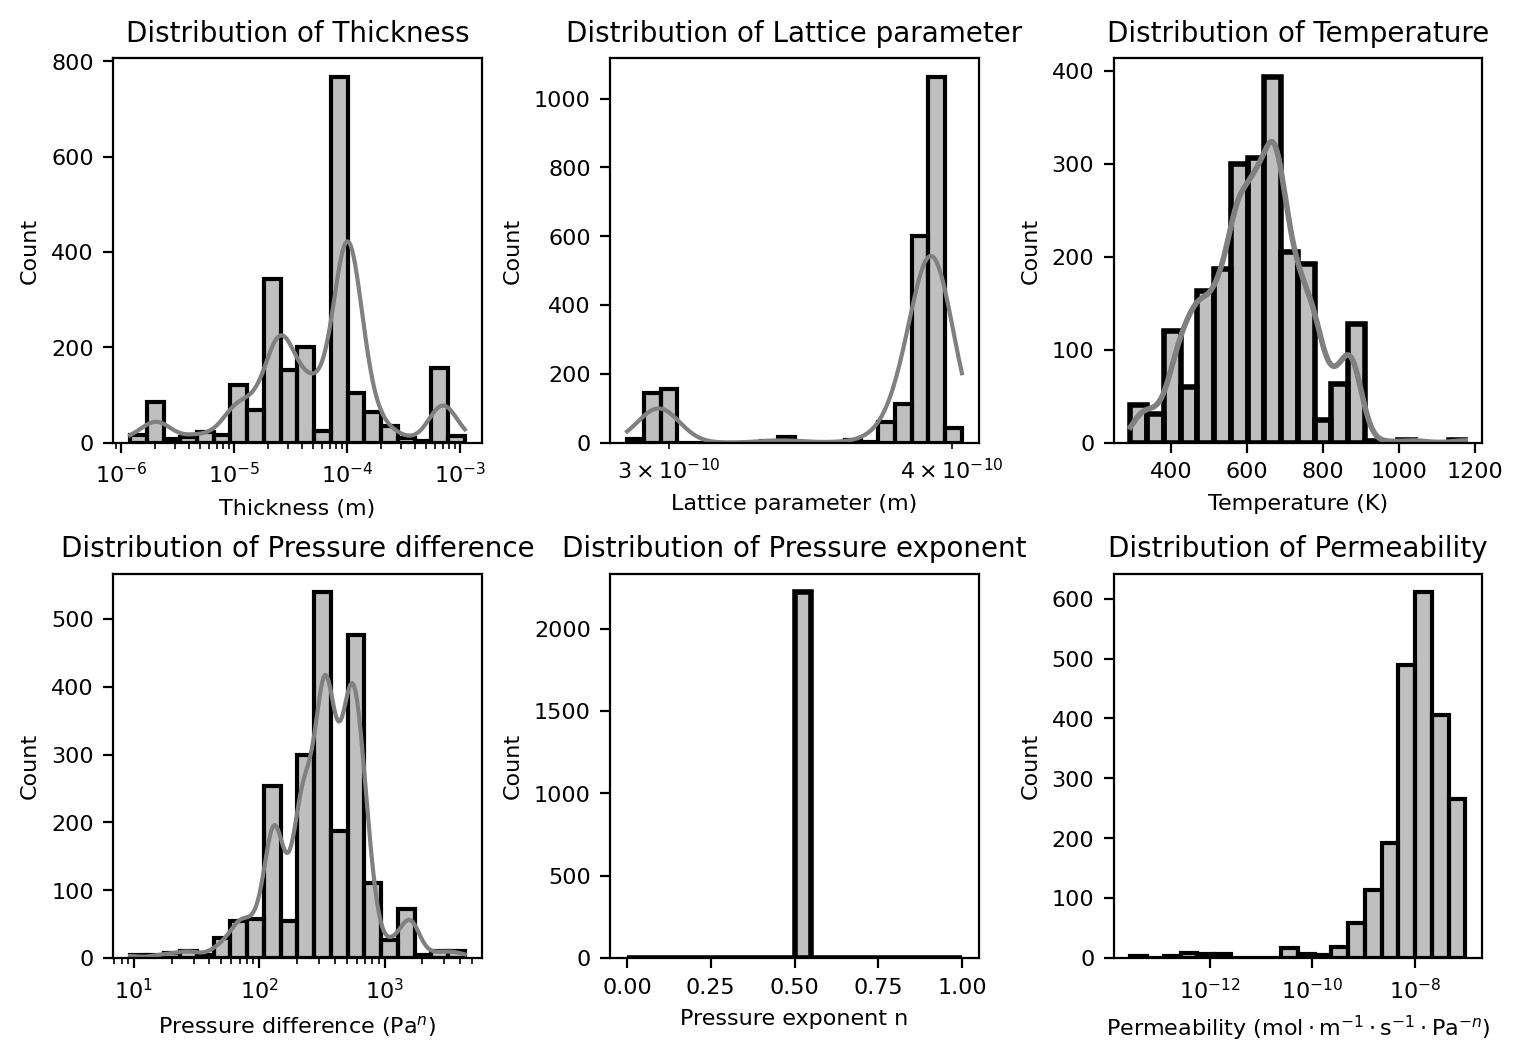

CPU times: user 8.7 s, sys: 259 ms, total: 8.96 s
Wall time: 13.5 s


In [ ]:
# define a function to plot the distribution of the experimental variables
#%%
%%time
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12 # Normally 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

unit_thickness = '(m)'
unit_lattice = '(m)'
unit_temperature = '(K)'
unit_pressure_difference = r'$\mathrm{Pa}^{n}$'
unit_pressure_exponent = 'n'
unit_permeability = r'$\mathrm{mol}\cdot \mathrm{m}^{-1} \cdot \mathrm{s}^{-1} \cdot \mathrm{Pa}^{-n}$'

def plot_histplot(dataframe, nrows, ncols, columns, figsize, dpi=600):

  fig, axes = plt.subplots(nrows, ncols, figsize=figsize, layout='constrained')  # We can adjust width for better spacing
  for i, ax in enumerate(axes.ravel()):
      if i < len(columns):
        if columns[i]!='Pressure exponent' and columns[i]!='Temperature':
          sns.histplot(data=df, x=columns[i], bins=20, color='gray', linewidth=1.5, log_scale=True, kde=True, line_kws={'color':'black', 'lw':1.5}, ax=ax)

        elif columns[i] in ['Pressure exponent', 'Temperature', 'Permeability']:
          sns.histplot(data=df, x=columns[i], bins=20, kde=True, color='gray', linewidth=2, line_kws={'color':'black', 'lw':2}, ax=ax) # We can adjust bins
      else:
          ax.axis('off')  # Hide unused subplots if any
      ax.set_title(f'Distribution of {columns[i]}')

      if columns[i] == 'Thickness':
        ax.set_xlabel(rf'Thickness {unit_thickness}')

      if columns[i] == 'Lattice parameter':
        ax.set_xlabel(rf'Lattice parameter {unit_lattice}')

      if columns[i] == 'Temperature':
        ax.set_xlabel(rf'Temperature {unit_temperature}')

      if columns[i] == 'Pressure difference':
        ax.set_xlabel(rf'Pressure difference ({unit_pressure_difference})')

      if columns[i] == 'Pressure exponent':
        ax.set_xlabel(f'Pressure exponent {unit_pressure_exponent}')

      if columns[i] == 'Permeability':
        ax.set_xlabel(rf'Permeability ({unit_permeability})')

  figure_1_name='Univariate_histogram_distribution_Exp.png'
  figure_1_path = os.path.join(Figure_dir, figure_1_name)
  plt.savefig(figure_1_path, dpi=600, bbox_inches='tight')

  plt.show()

#%%
to_show = ['Thickness', 'Lattice parameter', 'Temperature', 'Pressure difference', 'Pressure exponent', 'Permeability']

width = 7.5 # Define width before calling the function
height = 5.2  # Define height before calling the function
plot_histplot(dataframe=df, nrows=2, ncols=3, columns=to_show, figsize=(width,height))

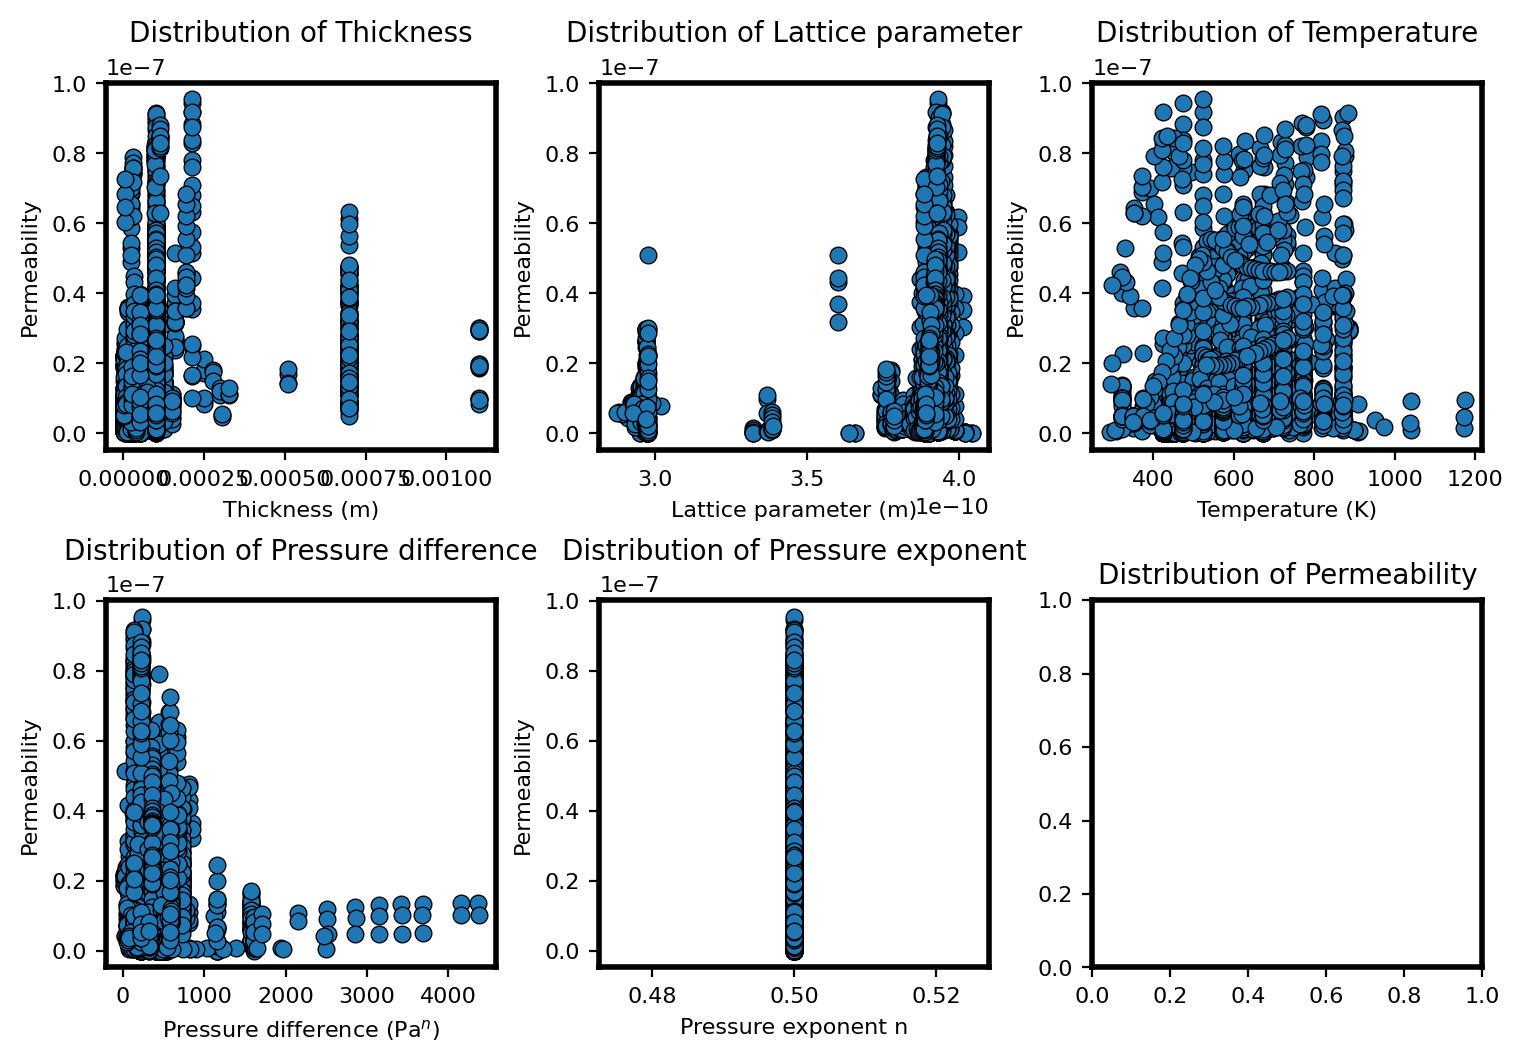

CPU times: user 14.4 s, sys: 395 ms, total: 14.7 s
Wall time: 16.6 s


In [ ]:
# define a function to show the distribution of the experimental variables
# %%
%%time
SMALLEST_SIZE = 2
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('axes', linewidth=SMALLEST_SIZE)  # linewidth of the two opposites x-axis and two opposite y-axis
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


unit_thickness = '(m)'
unit_lattice = '(m)'
unit_temperature = '(K)'
unit_pressure_difference = r'$\mathrm{Pa}^{n}$'
unit_pressure_exponent = 'n'
unit_permeability = r'$\mathrm{mol}\cdot \mathrm{m}^{-1} \cdot \mathrm{s}^{-1} \cdot \mathrm{Pa}^{-n}$'

def plot_histplot(dataframe, nrows, ncols, columns, figsize, dpi=600):
  fig, axes = plt.subplots(nrows, ncols, figsize=figsize, layout='constrained')  # We can adjust width for better spacing
  for i, ax in enumerate(axes.ravel()):

      if i < len(columns):
        if columns[i]!='Permeability':
          sns.scatterplot(data=df, x=columns[i], y='Permeability', ax=ax, edgecolors='black')
      else:
          ax.axis('off')  # Hide unused subplots if any
      ax.set_title(f'Distribution of {columns[i]}')

      if columns[i] == 'Thickness':
        ax.set_xlabel(rf'Thickness {unit_thickness}')

      if columns[i] == 'Lattice parameter':
        ax.set_xlabel(rf'Lattice parameter {unit_lattice}')

      if columns[i] == 'Temperature':
        ax.set_xlabel(rf'Temperature {unit_temperature}')

      if columns[i] == 'Pressure difference':
        ax.set_xlabel(rf'Pressure difference ({unit_pressure_difference})')

      if columns[i] == 'Pressure exponent':
        ax.set_xlabel(f'Pressure exponent {unit_pressure_exponent}')

      if columns[i] == 'log(Φ)':
        ax.set_xlabel(rf'({unit_permeability})')

  figure_1_name='Univariate_histogram_distribution_Exp.png'
  figure_1_path = os.path.join(Figure_dir, figure_1_name)
  plt.savefig(figure_1_path, dpi=600, bbox_inches='tight')

  plt.show()

#%%
to_show = ['Thickness', 'Lattice parameter', 'Temperature', 'Pressure difference', 'Pressure exponent', 'Permeability']

width = 7.5 # Define width before calling the function
height = 5.2  # Define height before calling the function
plot_histplot(dataframe=df, nrows=2, ncols=3, columns=to_show, figsize=(width,height))

In [ ]:
%%time
# Generate an EDA report
profile = ProfileReport(df[to_show], title = "Pd_alloy membranes report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 6/6 [00:00<00:00, 75.43it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 15.7 s, sys: 326 ms, total: 16 s
Wall time: 16.5 s


In [ ]:
# Printing the Fischer skewness and kurtosis using Pandas default skew() and kurtosis().Those indicators are unbiased in Pandas, i.e skewness=0 and kurtosis=0 mean same skewness and kurtosis as the normal distribution.
# Define a utility function to calculate skewness and Kurtosis

%%time
def skew_kurt(dataframe, columns):
  for i in columns:
    print(f'The skewness of variable {i} is: {dataframe[i].skew()}, its kurtosis is {dataframe[i].kurtosis()}')
    print('***'*45)

#%%
dataframe=df
columns=to_show
skew_kurt(dataframe, columns)

The skewness of variable Thickness is: 2.9903503771638182, its kurtosis is 8.478932959129395
***************************************************************************************************************************************
The skewness of variable Lattice parameter is: 0.0, its kurtosis is 0.0
***************************************************************************************************************************************
The skewness of variable Temperature is: 0.03247552499382603, its kurtosis is -0.01263892067124095
***************************************************************************************************************************************
The skewness of variable Pressure difference is: 4.135639888055518, its kurtosis is 25.541453693937992
***************************************************************************************************************************************
The skewness of variable Pressure exponent is: 0.0, its kurtosis is 0.0
*****************

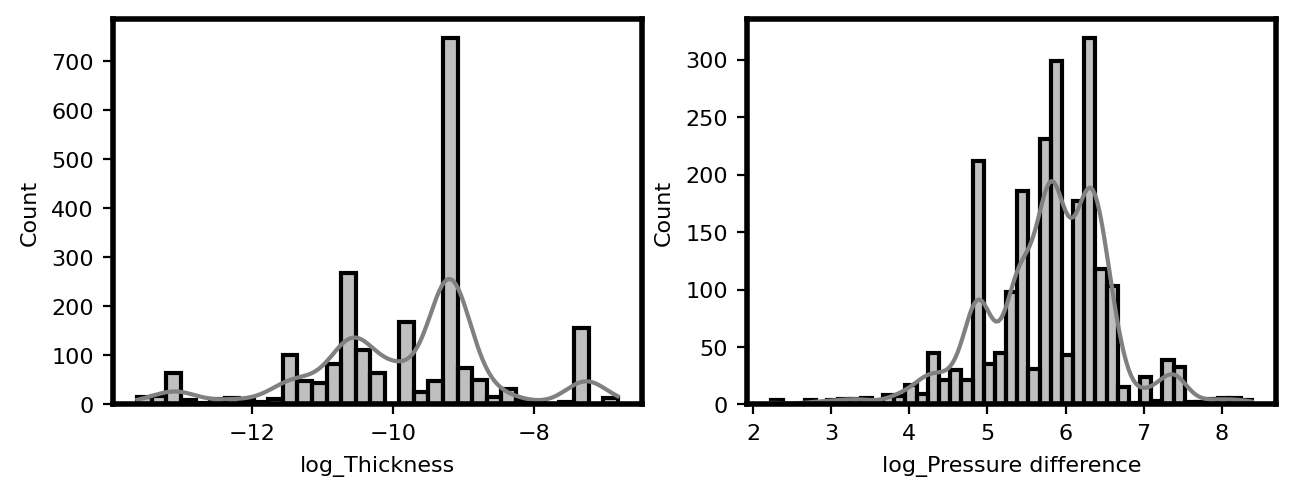

CPU times: user 1.26 s, sys: 9.91 ms, total: 1.27 s
Wall time: 1.42 s


In [ ]:
# Plot the log tranform
%%time
df2 = df.copy()
to_plot = ['log_Thickness', 'log_Pressure difference']
df2[to_plot] = df2[['Thickness', 'Pressure difference']].transform(np.log)
width = 7.5
height = 2.5
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(width, height))
for i, ax in enumerate(axs.ravel()):
  if i<len(to_plot):
    sns.histplot(data=df2[to_plot], x=to_plot[i], kde=True, color='gray', linewidth=1.5, line_kws={'color':'black', 'lw':1.5}, ax=ax)
plt.show()

In [ ]:
# Reprint skewness and kurtosis after log transformation
%%time
skew_kurt(dataframe=df2[to_plot], columns=to_plot)
# print('Skewness of log_Thickness:', df2['log_Thickness'].skew())
# print('Kurtosis of log_Tthickness:', df2['log_Thickness'].kurtosis())
# print('Skewness of log_Pressure difference:', df2['log_Pressure difference'].skew())
# print('Kurtosis of log_Pressure difference:', df2['log_Pressure difference'].kurtosis())

The skewness of variable log_Thickness is: -0.3873081459204237, its kurtosis is 0.6325609865277273
***************************************************************************************************************************************
The skewness of variable log_Pressure difference is: -0.45917472082983596, its kurtosis is 1.54233124844753
***************************************************************************************************************************************
CPU times: user 3.38 ms, sys: 0 ns, total: 3.38 ms
Wall time: 3.25 ms


In [ ]:
%%time
# Create a function to report the limits of the Z-Score
def print_z_score_limits (df, column_name):
    """ Print the upper and lower limits of the Z-score """

    # Compute the limits
    upper_limit = df[column_name].mean() + 3 * df[column_name].std()
    lower_limit = df[column_name].mean() - 3 * df[column_name].std()

    # Round and return the limits
    upper_limit = round(upper_limit, 10)
    lower_limit = round(lower_limit, 10)
    print_this = "Variable Name: " + column_name + " | Upper limit: " + str(upper_limit) + " | Lower limit: " + str(lower_limit)
    return(print_this)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


In [ ]:
%%time
# Print the upper and lower limits
print(print_z_score_limits(df, "Thickness"))
# print('Data falling in this range:', df[df['Thickness']<=0.0007245562].shape[0]/df.shape[0]*100,'%')
print('Data falling in this range:', df[(df['Thickness']<=0.0006791349) & (df['Thickness']>=-0.0004421699)].shape[0]/df.shape[0]*100,'%')

Variable Name: Thickness | Upper limit: 0.0006791349 | Lower limit: -0.0004421699
Data falling in this range: 92.35267656320289 %
CPU times: user 11.2 ms, sys: 3 µs, total: 11.2 ms
Wall time: 12.2 ms


In [ ]:
%%time
# Print the upper and lower limits
print(print_z_score_limits(df, "Temperature"))
print('Data falling in this range:', df[(df['Temperature']<=1031.3188556986) & (df['Temperature']>=213.5711611648)]['Temperature'].count()/df.shape[0]*100,'%') # Corrected the condition with parentheses
# Almost 99.5% of the data fall in the previous range (mean±3sigma) from the mean.

Variable Name: Temperature | Upper limit: 1023.1372892712 | Lower limit: 230.4083247638
Data falling in this range: 99.73009446693656 %
CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 13.4 ms


In [ ]:
%%time
# Since Temperature looks more gaussian we can explore how many data fall within +/-3sigma
sub=df[(df['Temperature']<=1031.3188556986) & (df['Temperature']>=213.5711611648)]
sub2=df[(df['Temperature']<=1031.3188556986) | (df['Temperature']>=213.5711611648)]
print(df.shape)
print(sub.shape)
print('Percentage of datapoints included within -/+3sigma:', sub.shape[0]/df.shape[0]*100,'%') # No trimming of the temperature is needed.

(2223, 56)
(2217, 56)
Percentage of datapoints included within -/+3sigma: 99.73009446693656 %
CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 16.8 ms


In [ ]:
%%time
# Print the upper and lower limits
for column in df2[to_plot]:
    print(print_z_score_limits(df2[to_plot], column))

Variable Name: log_Thickness | Upper limit: -5.859375232 | Lower limit: -13.8036514287
Variable Name: log_Pressure difference | Upper limit: 8.1779795581 | Lower limit: 3.373947264
CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 13.8 ms


In [ ]:
%%time
# Print the maximum values
print("MAXIMUM VALUES")
print(round(df2[to_plot].max(),2))
print("MINIMUM VALUES")
print(round(df2[to_plot].min(),2))
# After log transform the log_Thickness does not have any outliers since its max and min fall in the lower-upper limit. But Since 'log_Thickness' is multimodal, this approach does not seem legit

MAXIMUM VALUES
log_Thickness             -6.81
log_Pressure difference    8.38
dtype: float64
MINIMUM VALUES
log_Thickness             -13.63
log_Pressure difference     2.23
dtype: float64
CPU times: user 3.6 ms, sys: 973 µs, total: 4.58 ms
Wall time: 7.31 ms


In [ ]:
%%time
# Index of outliers to visualize them
index_outliers = df2[to_plot][(df2[to_plot]['log_Pressure difference']>=8.1779795581) | (df2[to_plot]['log_Pressure difference']<=3.373947264)].index

CPU times: user 4.23 ms, sys: 0 ns, total: 4.23 ms
Wall time: 6.22 ms


In [ ]:
%%time
df.iloc[index_outliers,:]

CPU times: user 801 µs, sys: 0 ns, total: 801 µs
Wall time: 915 µs


Alloy Formula Composition type  Form Composition in mole percent  \
879   Pd75Ag20Au2.5Ru2.5   weight percent  tube  Pd75.99Ag19.98Au1.37Ru2.67   
963         Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
965         Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
972         Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
973         Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
974         Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
981         Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
982         Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
984         Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
985         Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
987         Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
1032        Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
1033        Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
1034        Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
1036        Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
1038        Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
1039        Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
1040        Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
1041        Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
1043        Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
1044        Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
1045        Pd77.0Ag23.0   weight percent  foil              Pd77.25Ag22.75   
1078     Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1081     Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1087     Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1365         Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1366         Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1372         Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1456         Pd95.8Ti4.2   weight percent  tube               Pd91.12Ti8.88   

      Thickness  Lattice parameter Bravais lattice  Temperature  \
879    0.000160       3.930000e-10             fcc       853.15   
963    0.000001       3.931000e-10             fcc       573.15   
965    0.000001       3.931000e-10             fcc       573.15   
972    0.000002       3.931000e-10             fcc       573.15   
973    0.000002       3.931000e-10             fcc       573.15   
974    0.000002       3.931000e-10             fcc       573.15   
981    0.000002       3.931000e-10             fcc       573.15   
982    0.000002       3.931000e-10             fcc       573.15   
984    0.000005       3.931000e-10             fcc       573.15   
985    0.000005       3.931000e-10             fcc       573.15   
987    0.000030       3.931000e-10             fcc       673.15   
1032   0.000005       3.931000e-10             fcc       573.15   
1033   0.000005       3.931000e-10             fcc       573.15   
1034   0.000005       3.931000e-10             fcc       573.15   
1036   0.000002       3.931000e-10             fcc       573.15   
1038   0.000002       3.931000e-10             fcc       573.15   
1039   0.000002       3.931000e-10             fcc       573.15   
1040   0.000002       3.931000e-10             fcc       573.15   
1041   0.000002       3.931000e-10             fcc       573.15   
1043   0.000001       3.931000e-10             fcc       573.15   
1044   0.000001       3.931000e-10             fcc       573.15   
1045   0.000001       3.931000e-10             fcc       573.15   
1078   0.000085       3.874000e-10             fcc       323.15   
1081   0.000085       3.874000e-

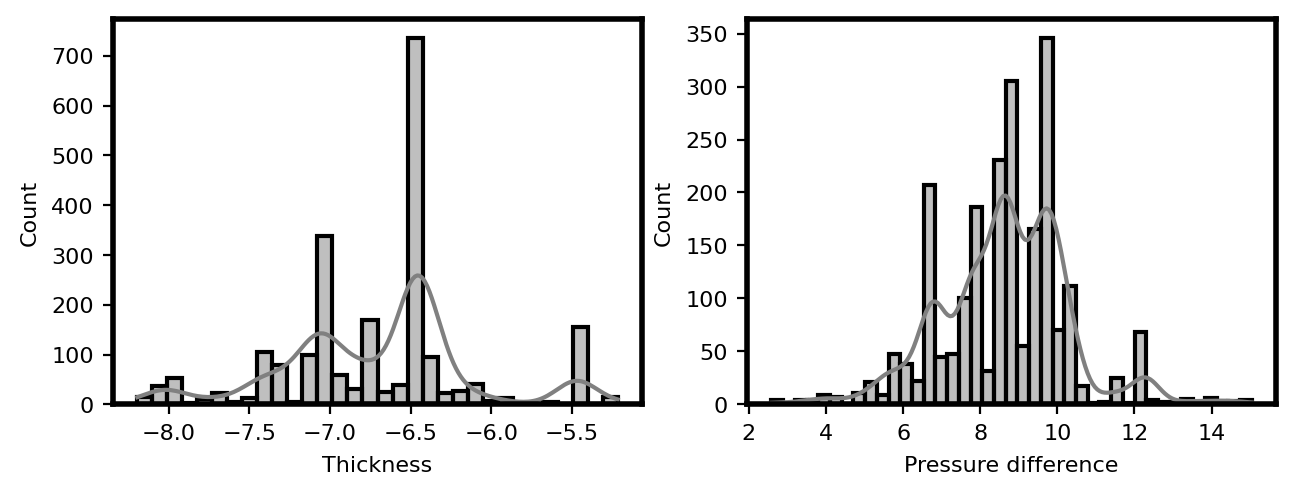

CPU times: user 1.44 s, sys: 11.9 ms, total: 1.45 s
Wall time: 1.47 s


In [ ]:
%%time
columns = ['Thickness','Pressure difference']
dfc=df.copy()
pt = PowerTransformer(method='box-cox', standardize=False) # Standardize=False because we will use the transform data for IsolationForest which does not need scaling. And In that case we can also evaluate if any other scaler would do great after PowerTransformer.
dfc_pt = pt.fit_transform(dfc[columns])

# convert the array back to a dataframe
dfc_pt_frame = pd.DataFrame(dfc_pt, columns=columns)

# histograms of the variables
width=7.5
height=2.5

fig, axs = plt.subplots(1, 2, figsize=(width, height))
for i, ax in enumerate(axs.ravel()):
  if i<len(to_plot):
    sns.histplot(data=dfc_pt_frame, x=columns[i], kde=True, color='gray', linewidth=1.5, line_kws={'color':'black', 'lw':1.5}, ax=ax)

plt.show()

In [ ]:
%%time
# Reprinting the kurtosis and skewness
# for i in columns:
#   skew_before, kurtosis_before=dfc[i].skew(), dfc[i].kurtosis()
#   skew_after, kurtosis_after=dfc_pt_frame[i].skew(), dfc_pt_frame[i].kurtosis()
#   print(f'BEFORE: The skewness of varible{i} is {skew_before} and its kurtosis is {kurtosis_before}')
#   print(f'AFTER: The skewness of variable {i} is {skew_after} and its kurtosis is {kurtosis_after}')

print('***'*21, 'BEFORE', '***'*21)
skew_kurt(dataframe=dfc, columns=columns)
print('')
print('***'*21, 'AFTER', '***'*21)
skew_kurt(dataframe=dfc_pt_frame, columns=columns)

*************************************************************** BEFORE ***************************************************************
The skewness of variable Thickness is: 2.9903503771638182, its kurtosis is 8.478932959129395
***************************************************************************************************************************************
The skewness of variable Pressure difference is: 4.135639888055518, its kurtosis is 25.541453693937992
***************************************************************************************************************************************

*************************************************************** AFTER ***************************************************************
The skewness of variable Thickness is: 0.01656211307407613, its kurtosis is 0.4854583202807494
***************************************************************************************************************************************
The skewness of variable Pressu

In [ ]:
%%time
# D'Agostino-Pearson test for normality (p-value<0.05 provide evidence against the null hypothesis. The inverse is not True.)
# Here the p-value are low so this is an evidence that although the PowerTransformation was done, still the sample does not look like drawn from normal distribution.
# Reference to the method at url: https://medium.com/@patricklcavins/using-scipys-powertransformer-3e2b792fd712

for i in dfc_pt_frame.columns.to_list():
  stat, p = sc.stats.normaltest(dfc_pt_frame[i])
  print (f'{i}: Statistic={stat}, p={p}')
  print ('--'*25)
# interpret
  alpha = 0.05
  if p > alpha:
      print(f'{i}: Sample looks Gaussian (fail to reject H0)')
  else:
      print(f'{i}: Sample does not look Gaussian (reject H0)')

Thickness: Statistic=15.02713657314179, p=0.0005456306444104294
--------------------------------------------------
Thickness: Sample does not look Gaussian (reject H0)
Pressure difference: Statistic=62.098621498469406, p=3.276843307323472e-14
--------------------------------------------------
Pressure difference: Sample does not look Gaussian (reject H0)
CPU times: user 4.72 ms, sys: 0 ns, total: 4.72 ms
Wall time: 5.46 ms


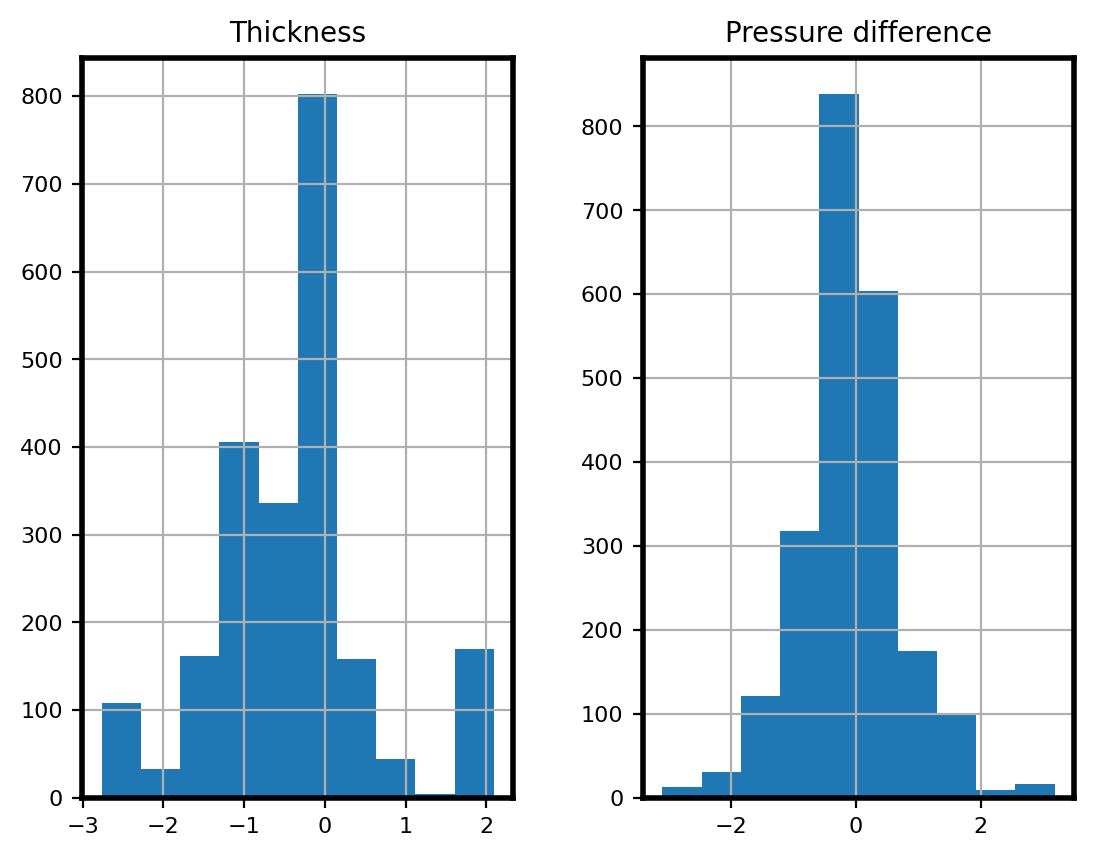

CPU times: user 2.01 s, sys: 36.9 ms, total: 2.05 s
Wall time: 1.97 s


In [ ]:
%%time
rs=RobustScaler()
dfc_rs=rs.fit_transform(dfc_pt_frame)
dfc_rs_frame=pd.DataFrame(dfc_rs, columns=dfc_pt_frame.columns.to_list())
dfc_rs_frame.hist()
plt.show()

In [ ]:
%%time
# RobustScaling is a linear transform and will not change skewness and kurtosis
for i in columns:
  skew_before, kurtosis_before=dfc_pt_frame[i].skew(), dfc_pt_frame[i].kurtosis()
  skew_after, kurtosis_after=dfc_rs_frame[i].skew(), dfc_rs_frame[i].kurtosis()
  print(f'BEFORE: The skewness of variable {i} is {skew_before} and its kurtosis is {kurtosis_before}')
  print(f'AFTER: The skewness of variable {i} is {skew_after} and its kurtosis is {kurtosis_after}')

BEFORE: The skewness of variable Thickness is 0.01656211307407613 and its kurtosis is 0.4854583202807494
AFTER: The skewness of variable Thickness is 0.01656211307407839 and its kurtosis is 0.48545832028074987
BEFORE: The skewness of variable Pressure difference is 0.04148681574715815 and its kurtosis is 1.275701396327567
AFTER: The skewness of variable Pressure difference is 0.04148681574715983 and its kurtosis is 1.275701396327567
CPU times: user 13.2 ms, sys: 0 ns, total: 13.2 ms
Wall time: 14.2 ms


In [ ]:
%%time
# The data are not Gaussian after PowerTransformer as given by the D'Agustino-Pearson Test. But the value of skewness and kurtosis are more interesting in the case of Box-Cox. RobustScaler hasn't changed anything. For that reason we will apply  MAD for outlier detection instead of z-score
# Reference: https://www.numberanalytics.com/blog/5-uses-of-mad-for-outlier-detection#google_vignette

def remove_outliers_mad(data, threshold=3): #By increasing the threshold the number of outliers detected increase
    mad = sc.stats.median_abs_deviation(data, axis=0, scale=1)
    median = np.median(data, axis=0)
    deviations = np.abs(data - median) / mad
    outliers = np.all(deviations>=threshold, axis=1)
    return data[~outliers], outliers

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


In [ ]:
%%time
data = dfc_pt_frame
df_copy_outliers_removed, outliers=remove_outliers_mad(data, threshold=3)

CPU times: user 26.3 ms, sys: 1 ms, total: 27.3 ms
Wall time: 26.7 ms


In [ ]:
%%time
index_clean = df_copy_outliers_removed.index
index = dfc.index
index_outliers = [i for i in index if i not in index_clean]
outlier_frame = dfc.iloc[index_outliers,:]

CPU times: user 7.64 ms, sys: 0 ns, total: 7.64 ms
Wall time: 7.56 ms


In [ ]:
%%time
# The number of outliers detected can be accepted
print(outlier_frame.shape)
outlier_frame

(39, 56)
CPU times: user 788 µs, sys: 9 µs, total: 797 µs
Wall time: 937 µs


Alloy Formula Composition type                            Form  \
89              Pd     mole percent                            foil   
102             Pd     mole percent                            foil   
108             Pd     mole percent                            foil   
114             Pd     mole percent                            foil   
453   Pd60.0Cu40.0   weight percent  foil prepared on Silicon wafer   
963   Pd77.0Ag23.0   weight percent                            foil   
965   Pd77.0Ag23.0   weight percent                            foil   
971   Pd77.0Ag23.0   weight percent                            foil   
972   Pd77.0Ag23.0   weight percent                            foil   
973   Pd77.0Ag23.0   weight percent                            foil   
974   Pd77.0Ag23.0   weight percent                            foil   
981   Pd77.0Ag23.0   weight percent                            foil   
982   Pd77.0Ag23.0   weight percent                            foil   
983   Pd77.0Ag23.0   weight percent                            foil   
984   Pd77.0Ag23.0   weight percent                            foil   
985   Pd77.0Ag23.0   weight percent                            foil   
992       Pd77Ag23   weight percent                            foil   
993       Pd77Ag23   weight percent                            foil   
994       Pd77Ag23   weight percent                            foil   
995       Pd77Ag23   weight percent                            foil   
1032  Pd77.0Ag23.0   weight percent                            foil   
1033  Pd77.0Ag23.0   weight percent                            foil   
1034  Pd77.0Ag23.0   weight percent                            foil   
1035  Pd77.0Ag23.0   weight percent                            foil   
1036  Pd77.0Ag23.0   weight percent                            foil   
1038  Pd77.0Ag23.0   weight percent                            foil   
1039  Pd77.0Ag23.0   weight percent                            foil   
1040  Pd77.0Ag23.0   weight percent                            foil   
1041  Pd77.0Ag23.0   weight percent                            foil   
1042  Pd77.0Ag23.0   weight percent                            foil   
1043  Pd77.0Ag23.0   weight percent                            foil   
1044  Pd77.0Ag23.0   weight percent                            foil   
1045  Pd77.0Ag23.0   weight percent                            foil   
1046      Pd77Ag23   weight percent                            foil   
1169  Pd83.2Cu16.8     mole percent                            foil   
1343  Pd90.0Ag10.0     mole percent                            foil   
1346  Pd90.0Ag10.0     mole percent                            foil   
1351  Pd90.0Ag10.0     mole percent                            foil   
1898   Pd94.2Cu5.8     mole percent                            foil   

     Composition in mole percent  Thickness  Lattice parameter  \
89                            Pd   0.000010       3.890000e-10   
102                           Pd   0.000010       3.890000e-10   
108                           Pd   0.000010       3.890000e-10   
114                           Pd   0.000010       3.890000e-10   
453               Pd47.25Cu52.75   0.000013       2.974183e-10   
963               Pd77.25Ag22.75   0.000001       3.931000e-10   
965               Pd77.25Ag22.75   0.000001       3.931000e-10   
971               Pd77.25Ag22.75   0.000002       3.931000e-10   
972               Pd77.25Ag22.75   0.000002       3.931000e-10   
973               Pd77.25Ag22.75   0.000002       3.931000e-10   
974               Pd77.25Ag22.75   0.000002       3.931000e-10   
981               Pd77.25Ag22.75   0.000002       3.931000e-10   
982               Pd77.25Ag22.75   0.000002       3.931000e-10   
983               Pd77.25Ag22.75   0.000005       3.931000e-10   
984               Pd77.25Ag22.75   0.000005       3.931000e-10   
985               Pd77.25Ag22.75   0.000005       3.931000e-10   
992               Pd77.25Ag22.75   0.00000

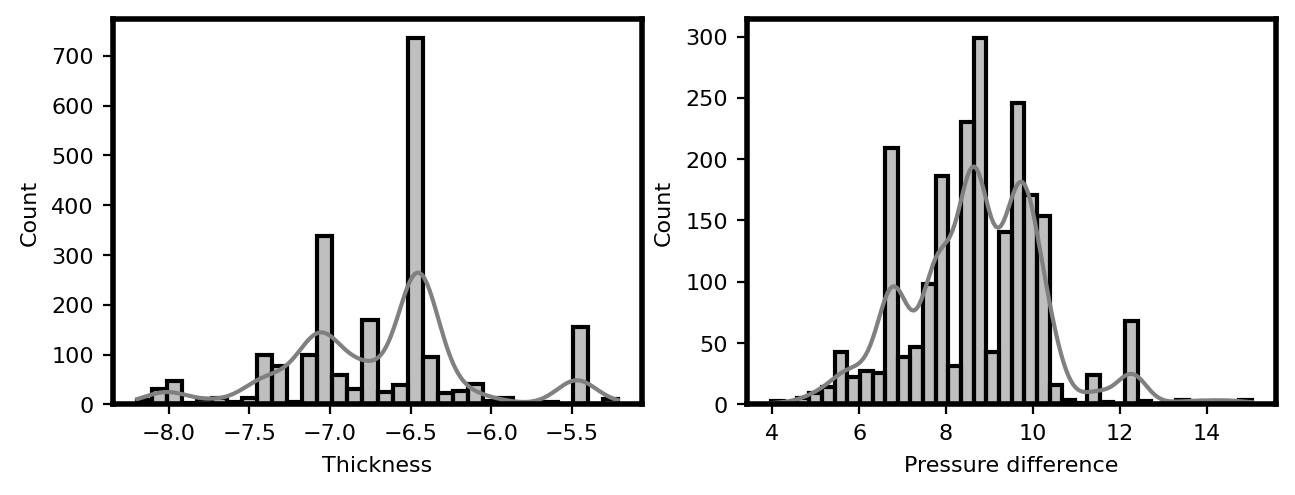

CPU times: user 3.63 s, sys: 54.1 ms, total: 3.68 s
Wall time: 3.35 s


In [ ]:
%%time
columns = df_copy_outliers_removed.columns.to_list() # We operate with the dataframe with outliers removed by MAD
width = 7.5
height = 2.5

# plot_histplot(dataframe=df_copy_outliers_removed, columns=columns, nrows=1, ncols=2, figsize=(width, height))
# df_copy_outliers_removed.hist()
# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(width, height))
for i, ax in enumerate(axs.ravel()):
  if i<len(to_plot):
    sns.histplot(data = df_copy_outliers_removed, x = columns[i], kde=True, color='gray', linewidth=1.5, line_kws={'color':'black', 'lw':1.5}, ax=ax)
plt.show()

In [ ]:
%%time
# The MAD-based trimming strategy did good to the pressure difference since both skewness and kurtosis decreased compared to when only PowerTransformer is used
print('*'*3, ' Pressure difference ', '*'*3)
print('Skewness: ', df_copy_outliers_removed['Pressure difference'].skew())
print('Kurtosis: ', df_copy_outliers_removed['Pressure difference'].kurtosis())

# The MAD-based trimmed harmed the kurtosis of 'Thickness' slightly, but overall it perform well
print('*'*3, ' Thickness ', '*'*3)
print('Skewness: ', df_copy_outliers_removed['Thickness'].skew())
print('Kurtosis: ', df_copy_outliers_removed['Thickness'].kurtosis())

***  Pressure difference  ***
Skewness:  0.31378738775319137
Kurtosis:  1.040834645350496
***  Thickness  ***
Skewness:  0.06223798395185089
Kurtosis:  0.5637080013208542
CPU times: user 12.6 ms, sys: 0 ns, total: 12.6 ms
Wall time: 14 ms


In [ ]:
%%time
# Apply Isolation Forest to the rest of the data
# Inliers=Gaussian Clusters
# Inliers=1
# Outliers=-1

# Initialize Isolation Forest with auto contamination and fixed random seed0.035
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, bootstrap=True, n_jobs=-1, random_state=42)

# Fit the model and predict outliers; -1 = outlier, 1 = inlier
df_copy_outliers_removed.loc[:,"iso_forest_outliers"] = iso_forest.fit_predict(df_copy_outliers_removed)

# Create a mask for detected outliers
outlier_mask = df_copy_outliers_removed["iso_forest_outliers"] == -1

# Display the rows detected as outliers
outliers_df=df_copy_outliers_removed[outlier_mask]
inliers_df=df_copy_outliers_removed[~outlier_mask]
index_outliers=outliers_df.index
df.iloc[index_outliers, :]

CPU times: user 2.6 s, sys: 44.1 ms, total: 2.64 s
Wall time: 2.61 s


Alloy Formula Composition type  Form Composition in mole percent  \
1078  Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1081  Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1085  Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1086  Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1087  Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1337     Pd90.0Ag10.0     mole percent  foil                Pd90.0Ag10.0   
1338     Pd90.0Ag10.0     mole percent  foil                Pd90.0Ag10.0   
1341     Pd90.0Ag10.0     mole percent  foil                Pd90.0Ag10.0   
1342     Pd90.0Ag10.0     mole percent  foil                Pd90.0Ag10.0   
1344     Pd90.0Ag10.0     mole percent  foil                Pd90.0Ag10.0   
1345     Pd90.0Ag10.0     mole percent  foil                Pd90.0Ag10.0   
1347     Pd90.0Ag10.0     mole percent  foil                Pd90.0Ag10.0   
1350     Pd90.0Ag10.0     mole percent  foil                Pd90.0Ag10.0   
1354     Pd90.0Ag10.0     mole percent  foil                Pd90.0Ag10.0   
1365      Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1366      Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1367      Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1368      Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1372      Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1456      Pd95.8Ti4.2   weight percent  tube               Pd91.12Ti8.88   
1457      Pd95.8Ti4.2   weight percent  tube               Pd91.12Ti8.88   
1458      Pd95.8Ti4.2   weight percent  tube               Pd91.12Ti8.88   

      Thickness  Lattice parameter Bravais lattice  Temperature  \
1078   0.000085       3.874000e-10             fcc       323.15   
1081   0.000085       3.874000e-10             fcc       323.15   
1085   0.000085       3.874000e-10             fcc       323.15   
1086   0.000085       3.874000e-10             fcc       323.15   
1087   0.000085       3.874000e-10             fcc       323.15   
1337   0.001100       3.906000e-10             fcc       887.15   
1338   0.001100       3.906000e-10             fcc       536.15   
1341   0.001100       3.906000e-10             fcc       887.15   
1342   0.001100       3.906000e-10             fcc       887.15   
1344   0.001100       3.906000e-10             fcc       887.15   
1345   0.001100       3.906000e-10             fcc       518.15   
1347   0.001100       3.906000e-10             fcc       689.15   
1350   0.001100       3.906000e-10             fcc       689.15   
1354   0.001100       3.906000e-10             fcc       538.15   
1365   0.000085       3.867000e-10             fcc       323.15   
1366   0.000085       3.867000e-10             fcc       323.15   
1367   0.000085       3.867000e-10             fcc       323.15   
1368   0.000085       3.867000e-10             fcc       323.15   
1372   0.000085       3.867000e-10             fcc       323.15   
1456   0.000085       3.887000e-10             fcc       323.15   
1457   0.000085       3.887000e-10             fcc       323.15   
1458   0.000085       3.887000e-10             fcc       323.15   

        Fabrication technique  Pressure difference  Pressure exponent  \
1078               Mechanical            4371.8779                0.5   
1081               Mechanical            4156.3497                0.5   
1085               Mechanical            3425.5295                0.5   
1086               Mechanical            3155.5213                0.5   
1087               Mechanical            3687.3325                0.5   
1337  Arc melting and rolling             136.6968                0.5   
1338  Arc melting and rolling              97.7003                0.5   
1341  Arc melting and rolling             105.9421                0.5   
1342  Arc melting and rolling              79.9893          

***  Pressure difference  ***
Skewness:  0.0661979590593956
Kurtosis:  0.40368950942739623
***  Thickness  ***
Skewness:  0.026335424808143555
Kurtosis:  0.538680840401581


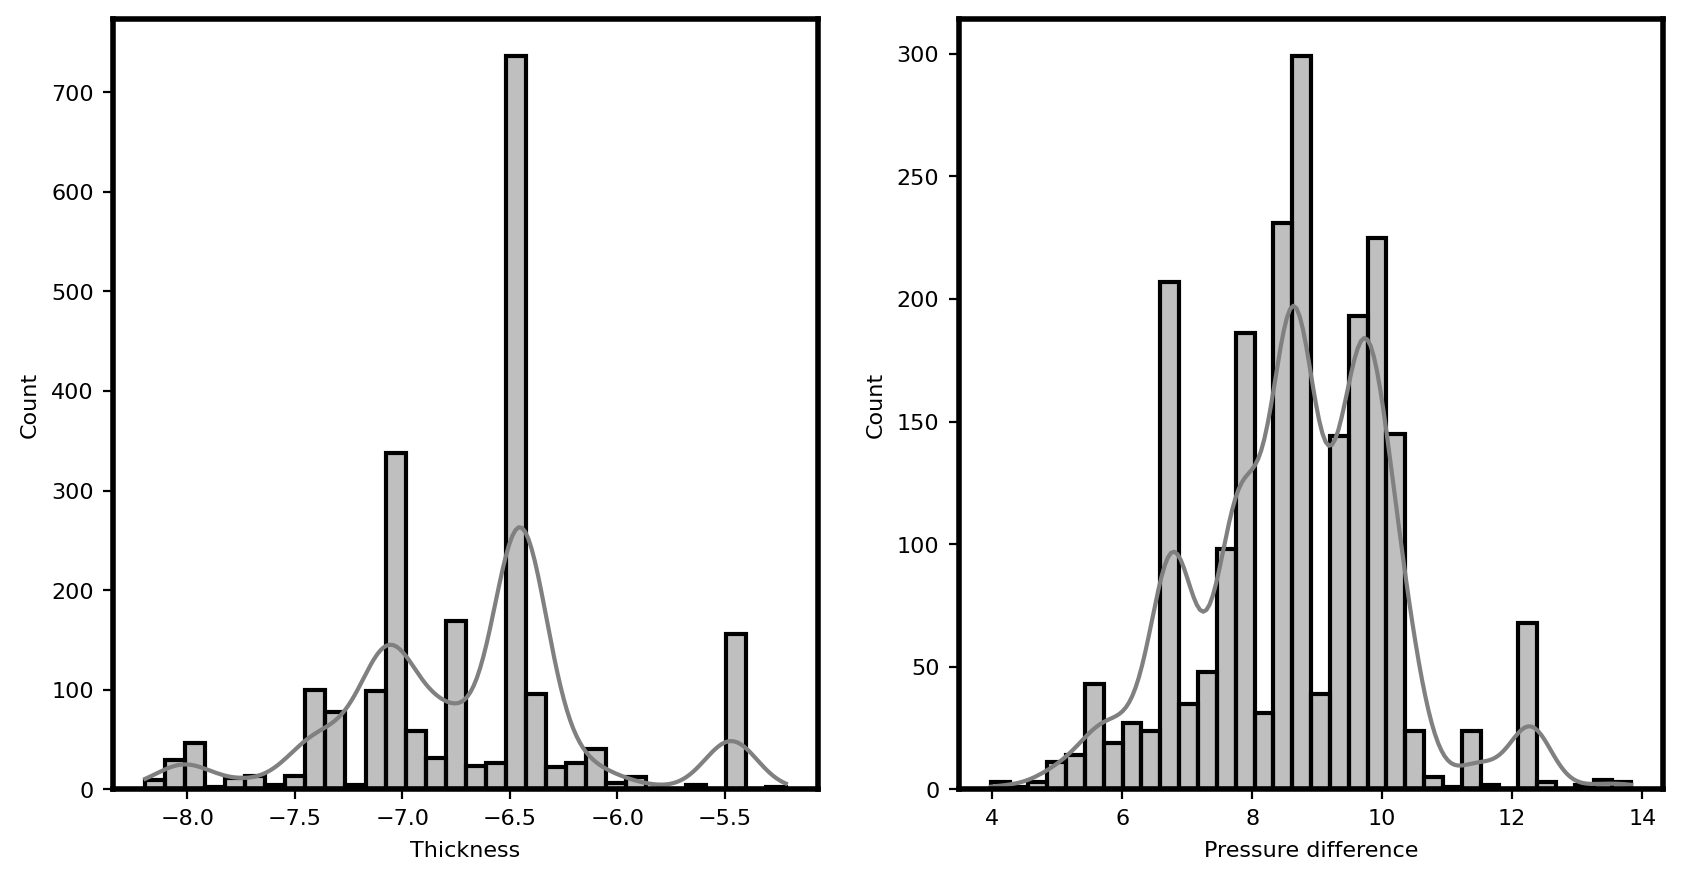

CPU times: user 670 ms, sys: 17 ms, total: 687 ms
Wall time: 496 ms


In [ ]:
%%time
print('*'*3, ' Pressure difference ', '*'*3)
print('Skewness: ', inliers_df['Pressure difference'].skew())
print('Kurtosis: ', inliers_df['Pressure difference'].kurtosis())

# The MAD-based trimmed harmed the kurtosis of 'Thickness' slightly, but overall it perform well
print('*'*3, ' Thickness ', '*'*3)
print('Skewness: ', inliers_df['Thickness'].skew())
print('Kurtosis: ', inliers_df['Thickness'].kurtosis())
dataframe=inliers_df.loc[:,['Thickness', 'Pressure difference']]
columns=['Thickness', 'Pressure difference']
width=10
height=5
# plot_histplot(dataframe=dataframe, columns=columns, nrows=1, ncols=2, figsize=(width,height))
# inliers_df.loc[:,['Thickness', 'Pressure difference']].hist()
# plt.show()
fig, axs = plt.subplots(1, 2, figsize=(width, height))
for i, ax in enumerate(axs.ravel()):
  if i<len(to_plot):
    sns.histplot(data=dataframe, x=columns[i], kde=True, color='gray', linewidth=1.5, line_kws={'color':'black', 'lw':1.5}, ax=ax)
plt.show()

In [ ]:
%%time
# Filter the dataset by cleaned index
# Saving the cleaned dataset (Created on April 4/24/2025)
cleaned_indices=inliers_df.index
# df_cleaned_final=df.iloc[inliers_index, :].copy()
PATH = '/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning'
file_path_inliers_index=os.path.join(PATH, "cleaned_indices.csv")
cleaned_indices.to_series().to_csv(file_path_inliers_index, index=False, header=['index'])
# Read the cleaned indices using the complete file path
df_cleaned_final = df.loc[pd.read_csv(file_path_inliers_index)["index"]]
file_path_clean_data = os.path.join(PATH, "df_cleaned_final.pkl")
df_cleaned_final.to_pickle(file_path_clean_data)
df_cleaned_final=pd.read_pickle(file_path_clean_data)

CPU times: user 37.5 ms, sys: 3.98 ms, total: 41.5 ms
Wall time: 512 ms


In [ ]:
%%time
# The number of unique compounds trimmed is fair. This means only real outliers composition was removed.
print('Unique compounds in the cleaned dataframe:', len(df_cleaned_final['Composition in mole percent'].unique()), 'Shape:',  df_cleaned_final.shape)
print('Unique compounds in the original dataframe:', len(df['Composition in mole percent'].unique()), 'Shape:',  df.shape)

Unique compounds in the cleaned dataframe: 328 Shape: (2162, 56)
Unique compounds in the original dataframe: 328 Shape: (2223, 56)
CPU times: user 1.03 ms, sys: 988 µs, total: 2.02 ms
Wall time: 2.57 ms


In [ ]:
%%time
df_cleaned_final.head()

CPU times: user 131 µs, sys: 2 µs, total: 133 µs
Wall time: 135 µs


Alloy Formula Composition type  Form Composition in mole percent  Thickness  \
0            Pd     mole percent  foil                          Pd    0.00025   
1            Pd     mole percent  disc                          Pd    0.00070   
2            Pd     mole percent  disc                          Pd    0.00070   
3            Pd     mole percent  disc                          Pd    0.00070   
4            Pd     mole percent  disc                          Pd    0.00070   

   Lattice parameter Bravais lattice  Temperature  Fabrication technique  \
0       3.887000e-10             fcc       737.15  Commercial Alfa Aesar   
1       3.890000e-10             fcc       673.15           Cold rolling   
2       3.890000e-10             fcc       673.15           Cold rolling   
3       3.890000e-10             fcc       673.15           Cold rolling   
4       3.890000e-10             fcc       623.15           Cold rolling   

   Pressure difference  Pressure exponent  Permeability  \
0             325.7194                0.5  9.240000e-09   
1             730.0685                0.5  1.320000e-08   
2             632.4555                0.5  1.260000e-08   
3             516.7204                0.5  1.260000e-08   
4             816.7007                0.5  1.120000e-08   

                                    General comments  \
0  Membrane A see the supplementary materials in ...   
1  Table 1 data were extracted for equation 7. Th...   
2  Table 1 data were extracted for equation 7. Th...   
3  Table 1 data were extracted for equation 7. Th...   
4  Table 1 data were extracted for equation 7. Th...   

                   Reference                                       DOI/URL  \
0  (Guerreiro  et al., 2016)  https://doi.org/10.1016/j.memsci.2016.02.040   
1    (Sakamoto et al., 1992)  https://doi.org/10.1016/0925-8388(92)90468-O   
2    (Sakamoto et al., 1992)  https://doi.org/10.1016/0925-8388(92)90468-O   
3    (Sakamoto et al., 1992)  https://doi.org/10.1016/0925-8388(92)90468-O   
4    (Sakamoto et al., 1992)  https://doi.org/10.1016/0925-8388(92)90468-O   

  Composition_matrix    B   Al   Ti    V   Cr   Mn   Fe   Co   Ni   Cu   Zn  \
0               (Pd)  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1               (Pd)  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2               (Pd)  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3               (Pd)  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4               (Pd)  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    Ga    Y   Zr   Nb   Mo   Ru   Rh   Pd   Ag   In   Sn   La   Ce   Pr   Sm  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    Gd   Tb   Dy   Ho   Er   Tm   Yb   Lu   Ta    W   Ir   Pt   Au   Pb  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [ ]:
%%time

# Feature scaling using RobustScaler
dfc = df.copy()
Features = ['Thickness', 'Temperature', 'Lattice parameter', 'Pressure difference', 'Pressure exponent']
X_unscaled = dfc[Features]
rs_f = RobustScaler()
X_scaled = rs_f.fit_transform(X_unscaled)
scaled_frame = pd.DataFrame(X_scaled, columns = Features)

# Outlier detection and removal using Isolation forest
# Initialize Isolation Forest with contamination level set to 1%
iso_forest = IsolationForest(n_estimators=100, contamination = 0.01, bootstrap=True, n_jobs=-1, random_state=42)

# Fit the model and predict outliers; -1 = outlier, 1 = inlier
scaled_frame.loc[:,"iso_forest_outliers"] = iso_forest.fit_predict(scaled_frame)

# Create a mask for detected outliers
outlier_mask = scaled_frame["iso_forest_outliers"] == -1

# Display the rows detected as outliers
outliers_df=scaled_frame[outlier_mask]
inliers_df=scaled_frame[~outlier_mask]
index_outliers=outliers_df.index
print('How many outliers?:', dfc.iloc[index_outliers, :].shape)
print('Remaining:', dfc.shape[0]-dfc.iloc[index_outliers, :].shape[0])
dfc.iloc[index_outliers, :]

How many outliers?: (23, 56)
Remaining: 2200
CPU times: user 251 ms, sys: 18.4 ms, total: 270 ms
Wall time: 249 ms


Alloy Formula Composition type  Form Composition in mole percent  \
139      Pd40.0Cu60.0   weight percent  foil              Pd28.48Cu71.52   
140      Pd40.0Cu60.0   weight percent  foil              Pd28.48Cu71.52   
170      Pd53.0Cu47.0   weight percent  foil              Pd40.25Cu59.75   
460      Pd60.0Cu40.0   weight percent  foil              Pd47.25Cu52.75   
479      Pd60.0Cu40.0   weight percent  foil              Pd47.25Cu52.75   
480      Pd60.0Cu40.0   weight percent  foil              Pd47.25Cu52.75   
695      Pd80.0Cu20.0   weight percent  foil              Pd70.49Cu29.51   
1078  Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1081  Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1085  Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1086  Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1087  Pd84.5Ag10Ni5.5   weight percent  tube         Pd80.99Ag9.45Ni9.56   
1342     Pd90.0Ag10.0     mole percent  foil                Pd90.0Ag10.0   
1343     Pd90.0Ag10.0     mole percent  foil                Pd90.0Ag10.0   
1365      Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1366      Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1367      Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1368      Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1372      Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1373      Pd94.5Ni5.5   weight percent  tube               Pd90.46Ni9.54   
1456      Pd95.8Ti4.2   weight percent  tube               Pd91.12Ti8.88   
1457      Pd95.8Ti4.2   weight percent  tube               Pd91.12Ti8.88   
1458      Pd95.8Ti4.2   weight percent  tube               Pd91.12Ti8.88   

      Thickness  Lattice parameter Bravais lattice  Temperature  \
139    0.000100       3.321517e-10         bcc/fcc      1173.28   
140    0.000100       3.321517e-10         bcc/fcc      1040.11   
170    0.000100       2.963192e-10             bcc       951.42   
460    0.000100       2.974183e-10             bcc      1173.33   
479    0.000100       2.974183e-10             bcc       972.69   
480    0.000100       2.974183e-10             bcc      1038.11   
695    0.000100       3.813847e-10             fcc      1174.56   
1078   0.000085       3.874000e-10             fcc       323.15   
1081   0.000085       3.874000e-10             fcc       323.15   
1085   0.000085       3.874000e-10             fcc       323.15   
1086   0.000085       3.874000e-10             fcc       323.15   
1087   0.000085       3.874000e-10             fcc       323.15   
1342   0.001100       3.906000e-10             fcc       887.15   
1343   0.001100       3.906000e-10             fcc       887.15   
1365   0.000085       3.867000e-10             fcc       323.15   
1366   0.000085       3.867000e-10             fcc       323.15   
1367   0.000085       3.867000e-10             fcc       323.15   
1368   0.000085       3.867000e-10             fcc       323.15   
1372   0.000085       3.867000e-10             fcc       323.15   
1373   0.000085       3.867000e-10             fcc       323.15   
1456   0.000085       3.887000e-10             fcc       323.15   
1457   0.000085       3.887000e-10             fcc       323.15   
1458   0.000085       3.887000e-10             fcc       323.15   

            Fabrication technique  Pressure difference  Pressure exponent  \
139   Vacuum-arc melting/ rolling            1612.4516                0.5   
140   Vacuum-arc melting/ rolling            1612.4516                0.5   
170   Vacuum-arc melting/ rolling            1612.4516                0.5   
460   Vacuum-arc melting/ rolling            1612.4516                0.5   
479   Vacuum-arc melting/ rolling            1612.4516                0.5   
480   Vacuum-arc melting/ rolling            1612.4516                0.5   
695   Vacuum-arc melting/ rolling  

In [ ]:
%%time
# Defining Path for data
PATH = '/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning'

#  Saving the data
file_path_clean_data = os.path.join(PATH, "df_cleaned_final.pkl")
dfc.to_pickle(file_path_clean_data)

CPU times: user 6.25 ms, sys: 1.99 ms, total: 8.24 ms
Wall time: 23.4 ms
